In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

In [3]:
DATA_PATH = '../data/processed/data_processed.csv'
data = pd.read_csv(DATA_PATH)

In [4]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [5]:
data['datetime'] = pd.to_datetime(data.datetime)

In [6]:
data_per_id = data.loc[data.machineID==1]

#### Maybe do some datetime calculations to create more features

In [7]:
data_cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','model_model1', 'model_model2', 'model_model3', 'model_model4']

target_cols = ['comp1_life']

In [8]:
N_features = len(data_cols)

In [9]:
X_df = data_per_id[data_cols]
y_df = data_per_id[target_cols]

X = X_df.values
y = y_df.values

In [10]:
train_size_pc = 0.85
train_idx = np.floor(train_size_pc*X.shape[0]).astype(int)

X_train = X[:train_idx]
X_test = X[train_idx:]

y_train = y[:train_idx]
y_test = y[train_idx:]

In [11]:
N_train = y_train.shape[0]
N_test = y_test.shape[0]

Try using an LDS to model the temporal dynamics of the measurements of each machine, per `machine_ID`.
The generative process is the following:  
$$
process
$$


In [12]:
def f(carry, inputs):
    
    u_input, noise_t = inputs
    
    beta1, beta2, z_prev1, z_prev2, tau, eta = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t  + jnp.dot(eta, u_input) 
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau, eta), z_t

In [128]:
def f2(carry, inputs):
        
    u_input, noise_t = inputs
    
    z_prev, betas, tau, R = carry
            
    # Create the B state matrix
    n_states_ = len(z_prev.flatten())
    B = jnp.eye(n_states_)
    
    # B[0] = betas
    B = B.at[0].set(betas)
        
    z_t = jnp.dot(B, z_prev) + tau*noise_t  + jnp.dot(R, u_input) 

    for i in range(len(z_prev.flatten())):
        # z_prev[i] = z_t[i]
        z_prev = z_prev.at[i].set(z_t[i])
      

    betas = B[0]
    
    print(f'betas: {betas.shape}')
    print(f'z_prev: {z_prev.shape}')
    print(f'tau: {tau.shape}')
    print(f"R: {R.shape}")
    print(f'z_t: {z_t.shape}')
    return (betas, z_prev, tau, R), z_t

In [138]:
def model(T, T_forecast, X, obs=None):
    """ Define priors over B, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    # Your code here
    """
    
    n_states = 24
    
    
#     beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=5.))
#     beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=5.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
#     noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
#     z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0., scale=3.))
#     z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0., scale=3.))
    
    noises = numpyro.sample("noises", fn=dist.Normal(jnp.zeros(T+T_forecast-n_states),
                                                    jnp.ones(T+T_forecast-n_states)))
    
    n, p = X.shape
            
    sigma_eta = 1.
    
    eta = numpyro.sample(name="eta", fn=dist.Normal(loc=jnp.zeros(p), scale=jnp.ones(p)*sigma_eta))
        
    scale_z = 3.
    z_prev = np.array([numpyro.sample(name=f"z_prev_{i}", fn=dist.Normal(loc=0., scale=scale_z)) for i in range(1,n_states+1)]) 
        
    scale_b = 5.
    betas = np.array([numpyro.sample(name=f"beta_{i}", fn=dist.Normal(loc=0., scale=scale_b)) for i in range(1,n_states+1)]) 
        
    """ Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    # Your code here
    """
    carry = (betas, z_prev, tau, eta)
    z_collection = [z_prev[i] for i in range(len(z_prev.flatten()))]
        
    carry, zs_exp = lax.scan(f2, carry, xs=[X,noises], length= T+T_forecast-n_states)
    
    print(jnp.array(z_collection).shape, zs_exp.shape)
    
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
    # Your code here
    """
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs[:T])
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [139]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

n_states = 24

X_t = np.concatenate([X_train[n_states:,:], X_test], axis=0)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, X=X_t , obs=y_train[:,0])

(24,) (2889, 24)


ValueError: Incompatible shapes for broadcasting: shapes=[(2476, 24), (2476,)]

In [16]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_1      0.08      0.03      0.09      0.03      0.11      2.57      2.39
      beta_2      0.78      0.04      0.78      0.72      0.83      2.77      2.21
      eta[0]     -0.03      0.00     -0.04     -0.04     -0.03      3.38      1.82
      eta[1]     -0.02      0.00     -0.02     -0.02     -0.01      4.14      1.55
      eta[2]      0.09      0.01      0.08      0.08      0.10      4.18      1.38
      eta[3]     -0.14      0.01     -0.14     -0.15     -0.13      2.45      2.84
      eta[4]     -0.10      0.00     -0.10     -0.10     -0.09      2.73      2.60
      eta[5]      0.04      0.00      0.04      0.04      0.04      3.88      1.47
      eta[6]     -0.09      0.00     -0.09     -0.09     -0.08     16.18      1.00
      eta[7]      0.11      0.01      0.11      0.10      0.12      7.24      1.53
      eta[8]      0.09      0.01      0.10      0.07      0.11      3.69      1.43
   

<Figure size 1000x300 with 0 Axes>

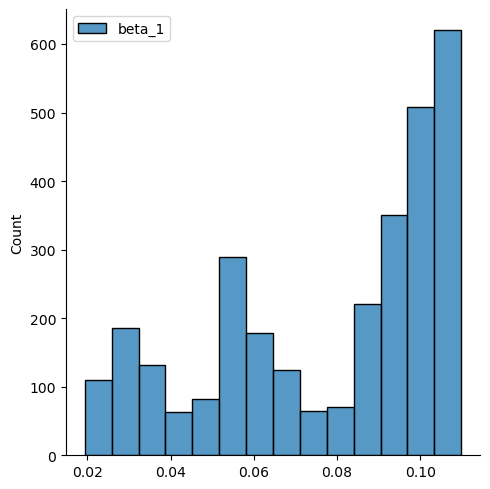

<Figure size 1000x300 with 0 Axes>

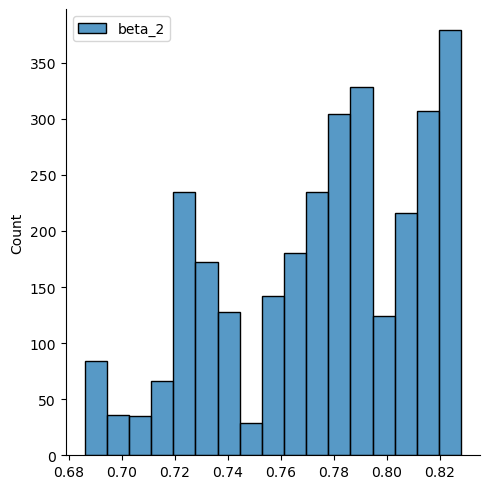

<Figure size 1000x300 with 0 Axes>

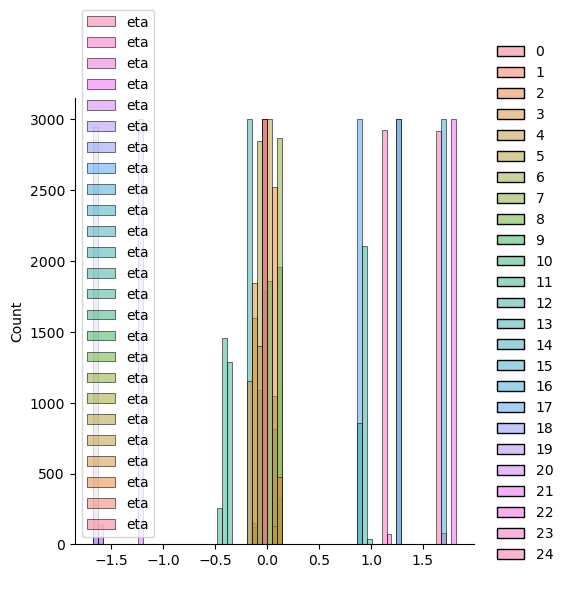

<Figure size 1000x300 with 0 Axes>

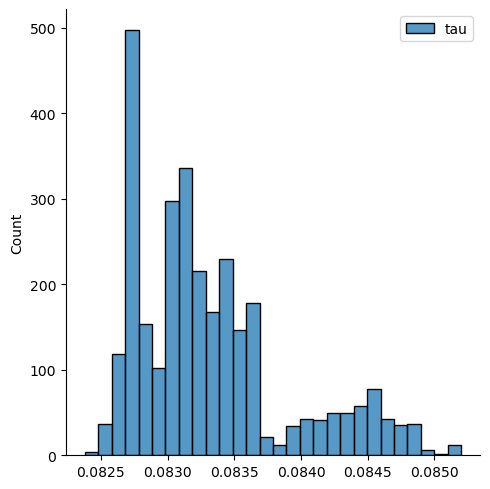

<Figure size 1000x300 with 0 Axes>

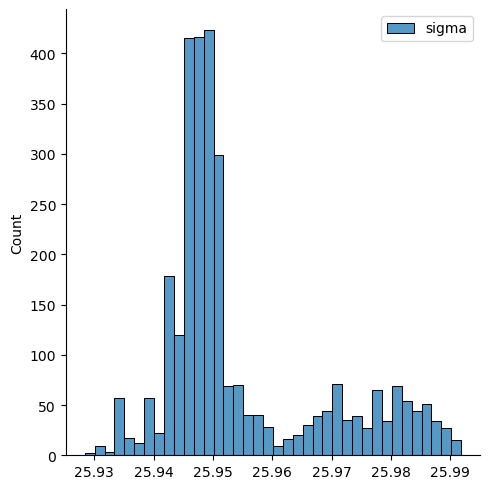

In [17]:
# Get parameter samples
samples_ = mcmc.get_samples()
nodes_ = ["beta_1", "beta_2","eta", "tau", "sigma"]
for node in nodes_:
    plt.figure(figsize=(10,3))
    sns.displot(samples_[node], label=node)
    plt.legend()
    plt.show()

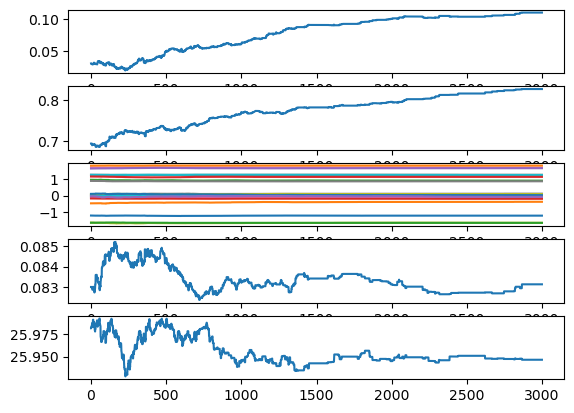

In [18]:
# Trace plots
f, ax = plt.subplots(5, 1)
ax[0].plot(samples_['beta_1'])
ax[1].plot(samples_['beta_2'])
ax[2].plot(samples_['eta'])
ax[3].plot(samples_['tau'])
ax[4].plot(samples_['sigma'])

In [19]:
def compute_predictions(samples):
    """
    Computes the mean and standard deviation of a given sample and re-normalizes the
    values given a certain mean and standard deviation. Returns a re-normalized vector.
    """

    y_hat_mean = samples.mean(axis=0).reshape(-1,)
    y_hat_std = samples.std(axis=0).reshape(-1,)
    # y_hat_025 = (y_hat_mean - 1.96*y_hat_std) * y_std + y_mean
    # y_hat_975 = (y_hat_mean + 1.96*y_hat_std) * y_std + y_mean
    y_hat_renormalized = y_hat_mean
    return y_hat_renormalized #, y_hat_025, y_hat_975

In [20]:
def compute_error(trues, predicted):
    """
    Computes the error given a vector of actual measurements against predicted. Returns
    a list with the correlation, MAE, RAE, RMSE, and R2 between these two vectors.
    """

    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return [corr, mae, rae, rmse, r2]

In [21]:
y_hat = compute_predictions(samples_["y_pred"])

In [22]:
y_hat.shape, y_test.shape

((437,), (437, 1))

In [23]:
compute_error(y_test.flatten(), y_hat)

[nan, nan, nan, nan, 0]

In [24]:
y_hat

Array([-0.89026994, -0.64659536, -0.26612312,  0.38283226, -0.87450886,
        1.1773521 , -1.0501348 ,  1.4879116 , -1.2058737 , -0.33497003,
        0.34430078, -0.49419335, -0.41827607, -0.31788525,  0.5431804 ,
       -0.5560092 ,  1.1181182 ,  1.0602274 ,  1.0232692 ,  1.6779517 ,
        1.2676953 , -0.7359953 ,  0.4822438 ,  0.2473324 ,  0.80639744,
       -1.0862633 ,  0.30590847, -2.3898416 ,  0.21738547, -2.1566954 ,
        0.25617474,  2.0480323 ,  1.6323831 , -0.95984083,  1.4000695 ,
       -0.40482545, -0.38741913, -0.50497234, -1.8862224 ,  1.7675505 ,
       -1.4854912 , -2.4048772 , -0.8290573 , -0.5977368 , -1.199075  ,
       -1.4883021 ,  0.59980047,  2.2478378 , -0.320087  ,  0.10041106,
        1.0678866 , -0.01927155, -0.32185128,  0.5827556 , -1.0424088 ,
        1.1767457 , -0.5649232 ,  1.3061922 , -0.4162401 ,  2.3140328 ,
        0.41395658,  0.14121735,  0.09678528, -2.0713785 , -0.5461974 ,
       -0.41700155, -1.449626  ,  1.9249681 ,  0.07804119, -0.75

In [25]:
y_test.flatten()

array([53.5  , 53.375, 53.25 , 53.125, 53.   , 52.875, 52.75 , 52.625,
       52.5  , 52.375, 52.25 , 52.125, 52.   , 51.875, 51.75 , 51.625,
       51.5  , 51.375, 51.25 , 51.125, 51.   , 50.875, 50.75 , 50.625,
       50.5  , 50.375, 50.25 , 50.125, 50.   , 49.875, 49.75 , 49.625,
       49.5  , 49.375, 49.25 , 49.125, 49.   , 48.875, 48.75 , 48.625,
       48.5  , 48.375, 48.25 , 48.125, 48.   , 47.875, 47.75 , 47.625,
       47.5  , 47.375, 47.25 , 47.125, 47.   , 46.875, 46.75 , 46.625,
       46.5  , 46.375, 46.25 , 46.125, 46.   , 45.875, 45.75 , 45.625,
       45.5  , 45.375, 45.25 , 45.125, 45.   , 44.875, 44.75 , 44.625,
       44.5  , 44.375, 44.25 , 44.125, 44.   , 43.875, 43.75 , 43.625,
       43.5  , 43.375, 43.25 , 43.125, 43.   , 42.875, 42.75 , 42.625,
       42.5  , 42.375, 42.25 , 42.125, 42.   , 41.875, 41.75 , 41.625,
       41.5  , 41.375, 41.25 , 41.125, 41.   , 40.875, 40.75 , 40.625,
       40.5  , 40.375, 40.25 , 40.125, 40.   , 39.875, 39.75 , 39.625,
      

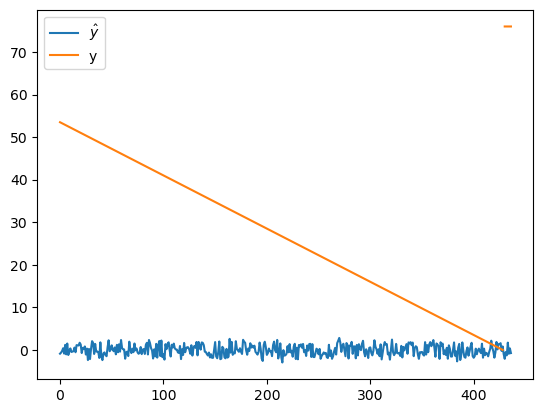

In [26]:
plt.plot(y_hat, label='$\hat{y}$')
plt.plot(y_test, label='y')
plt.legend()
plt.show()